In [ ]:
# BERT

In [ ]:
from collections import defaultdict
from urllib import request
import json
import pandas as pd

def parse_conllu_using_pandas(block):
    records = []
    for line in block.splitlines():
        if not line.startswith('#'):
            records.append(line.strip().split('\t'))
    return pd.DataFrame.from_records(
        records,
        columns=['ID', 'FORM', 'TAG', 'Misc1', 'Misc2'])

def tokens_to_labels(df):
    return (
        df.FORM.tolist(),
        df.TAG.tolist()
    )

PREFIX = "https://raw.githubusercontent.com/UniversalNER/"
DATA_URLS = {
    "en_ewt": {
        "train": "UNER_English-EWT/master/en_ewt-ud-train.iob2",
        "dev": "UNER_English-EWT/master/en_ewt-ud-dev.iob2",
        "test": "UNER_English-EWT/master/en_ewt-ud-test.iob2"
    },
    "en_pud": {
        "test": "UNER_English-PUD/master/en_pud-ud-test.iob2"
    }
}

# en_ewt is the main train-dev-test split
# en_pud is the OOD test set
data_dict = defaultdict(dict)
for corpus, split_dict in DATA_URLS.items():
    for split, url_suffix in split_dict.items():
        url = PREFIX + url_suffix
        with request.urlopen(url) as response:
            txt = response.read().decode('utf-8')
            data_frames = map(parse_conllu_using_pandas,
                              txt.split('\n\n'))
            token_label_alignments = list(map(tokens_to_labels,
                                              data_frames))
            data_dict[corpus][split] = token_label_alignments

# Saving the data so that you don't have to redownload it each time.
with open('ner_data_dict.json', 'w', encoding='utf-8') as out:
    json.dump(data_dict, out, indent=2, ensure_ascii=False)

# Each subset of each corpus is a list of tuples where each tuple
# is a list of tokens with a corresponding list of labels.

# Train on data_dict['en_ewt']['train']; validate on data_dict['en_ewt']['dev']
# and test on data_dict['en_ewt']['test'] and data_dict['en_pud']['test']
data_dict['en_ewt']['train'][0], data_dict['en_pud']['test'][1]

((['Where', 'in', 'the', 'world', 'is', 'Iguazu', '?'],
  ['O', 'O', 'O', 'O', 'O', 'B-LOC', 'O']),
 (['For',
   'those',
   'who',
   'follow',
   'social',
   'media',
   'transitions',
   'on',
   'Capitol',
   'Hill',
   ',',
   'this',
   'will',
   'be',
   'a',
   'little',
   'different',
   '.'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B-LOC',
   'I-LOC',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']))

In [ ]:
# Tap mapping

tag_set = sorted({tag for tokens, labels in data_dict['en_ewt']['train'] for tag in labels})
tag2id = {tag: i for i, tag in enumerate(tag_set)}
id2tag = {i: tag for tag, i in tag2id.items()}


In [ ]:
# Dataset class (with BERT alignment)

from transformers import BertTokenizerFast
from torch.utils.data import Dataset

tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

class NERDataset(Dataset):
    def __init__(self, data, tag2id):
        self.data = data
        self.tag2id = tag2id

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens, labels = self.data[idx]
        encoding = tokenizer(tokens,
                             is_split_into_words=True,
                             truncation=True,
                             padding='max_length',
                             max_length=128,
                             return_offsets_mapping=True)

        word_ids = encoding.word_ids()
        aligned_labels = []
        prev_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                aligned_labels.append(-100)
            elif word_idx != prev_word_idx:
                aligned_labels.append(self.tag2id[labels[word_idx]])
            else:
                aligned_labels.append(self.tag2id[labels[word_idx]] if labels[word_idx].startswith("I-") else -100)
            prev_word_idx = word_idx

        encoding.pop("offset_mapping")
        encoding["labels"] = aligned_labels
        return {k: torch.tensor(v) for k, v in encoding.items()}

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Model training

from transformers import BertForTokenClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(tag2id)).to(device)

train_dataset = NERDataset(data_dict["en_ewt"]["train"], tag2id)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

optimizer = AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(3):
    total_loss = 0
    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: loss = {total_loss:.4f}")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1568/1568 [04:52<00:00,  5.36it/s]


Epoch 1: loss = 104.9194


100%|██████████| 1568/1568 [04:57<00:00,  5.27it/s]


Epoch 2: loss = 41.4587


100%|██████████| 1568/1568 [04:56<00:00,  5.28it/s]

Epoch 3: loss = 25.9982


In [ ]:
# Evaluate model on test set

def extract_spans(labels, id2tag):
    spans = []
    span = []
    label_type = None
    for i, label_id in enumerate(labels):
        tag = id2tag.get(label_id, "O")
        if tag.startswith("B-"):
            if span:
                spans.append((label_type, tuple(span)))
            span = [i]
            label_type = tag[2:]
        elif tag.startswith("I-") and label_type:
            span.append(i)
        else:
            if span:
                spans.append((label_type, tuple(span)))
            span = []
            label_type = None
    if span:
        spans.append((label_type, tuple(span)))
    return spans

In [ ]:
def evaluate(model, dataset, tag2id, id2tag):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=8)
    true_spans, pred_spans = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            labels = batch["labels"].numpy()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

            for i in range(len(labels)):
                true = [l for l, m in zip(labels[i], batch["attention_mask"][i]) if m == 1 and l != -100]
                pred = [p for p, l, m in zip(preds[i], labels[i], batch["attention_mask"][i]) if m == 1 and l != -100]
                true_spans.extend(extract_spans(true, id2tag))
                pred_spans.extend(extract_spans(pred, id2tag))

    true_set = set(true_spans)
    pred_set = set(pred_spans)
    correct = true_set & pred_set

    precision = len(correct) / len(pred_set) if pred_set else 0
    recall = len(correct) / len(true_set) if true_set else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall else 0

    print(f"Labelled Span Matching — Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

In [ ]:
# Run evaluation

test_dataset = NERDataset(data_dict["en_ewt"]["test"], tag2id)
evaluate(model, test_dataset, tag2id, id2tag)


100%|██████████| 260/260 [00:16<00:00, 16.02it/s]

Labelled Span Matching — Precision: 0.8635, Recall: 0.8490, F1: 0.8562


In [ ]:
# Simplify labels to B/I/O and create dataset

def simplify_labels(labels):
    return ['O' if tag == 'O' else tag.split('-')[0] for tag in labels]

# Create new tag set and mappings
simplified_tag_set = sorted({t for _, labels in data_dict['en_ewt']['train'] for t in simplify_labels(labels)})
simpl_tag2id = {tag: i for i, tag in enumerate(simplified_tag_set)}
simpl_id2tag = {i: tag for tag, i in simpl_tag2id.items()}

# New dataset class using simplified labels
class SimplifiedNERDataset(NERDataset):
    def __getitem__(self, idx):
        tokens, labels = self.data[idx]
        labels = simplify_labels(labels)  # <- key difference
        encoding = tokenizer(tokens,
                             is_split_into_words=True,
                             truncation=True,
                             padding='max_length',
                             max_length=128,
                             return_offsets_mapping=True)
        word_ids = encoding.word_ids()
        aligned_labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                aligned_labels.append(-100)
            elif word_idx != previous_word_idx:
                aligned_labels.append(self.tag2id[labels[word_idx]])
            else:
                aligned_labels.append(self.tag2id[labels[word_idx]] if labels[word_idx] == 'I' else -100)
            previous_word_idx = word_idx
        encoding.pop("offset_mapping")
        encoding["labels"] = aligned_labels
        return {k: torch.tensor(v) for k, v in encoding.items()}

In [ ]:
# Evaluate with per-label F1 and macro-F1

from sklearn.metrics import precision_recall_fscore_support

def evaluate_with_f1(model, dataset, id2tag):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=8)
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            labels = batch["labels"].numpy()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

            for i in range(len(labels)):
                true = [l for l, m in zip(labels[i], batch["attention_mask"][i]) if m == 1 and l != -100]
                pred = [p for p, l, m in zip(preds[i], labels[i], batch["attention_mask"][i]) if m == 1 and l != -100]
                all_labels.extend(true)
                all_preds.extend(pred)

    target_names = [id2tag[i] for i in sorted(id2tag)]
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, labels=list(range(len(target_names))), zero_division=0)

    print("\nPer-label performance:")
    for label, p, r, f in zip(target_names, precision, recall, f1):
        print(f"{label:<5}  P: {p:.3f}  R: {r:.3f}  F1: {f:.3f}")

    macro_f1 = sum(f1) / len(f1)
    print(f"\nMacro-averaged F1: {macro_f1:.4f}")

In [ ]:
# evaluate on simplified en_ewt test set

simpl_test_dataset = SimplifiedNERDataset(data_dict["en_ewt"]["test"], simpl_tag2id)
evaluate_with_f1(model, simpl_test_dataset, simpl_id2tag)


100%|██████████| 260/260 [00:16<00:00, 15.87it/s]


Per-label performance:
B      P: 0.909  R: 0.265  F1: 0.410
I      P: 0.029  R: 0.009  F1: 0.014
O      P: 0.052  R: 0.001  F1: 0.002

Macro-averaged F1: 0.1421


In [ ]:
# Evaluate on Out-of-Domain (en_pud) test set

simpl_pud_dataset = SimplifiedNERDataset(data_dict["en_pud"]["test"], simpl_tag2id)
evaluate_with_f1(model, simpl_pud_dataset, simpl_id2tag)

100%|██████████| 126/126 [00:08<00:00, 15.63it/s]



Per-label performance:
B      P: 0.890  R: 0.392  F1: 0.544
I      P: 0.037  R: 0.009  F1: 0.014
O      P: 0.060  R: 0.001  F1: 0.003

Macro-averaged F1: 0.1868


In [ ]:
# T5

In [ ]:
!pip install -q transformers datasets

import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments
from torch.utils.data import Dataset
from datasets import Dataset as HFDataset
from tqdm import tqdm
import numpy as np


In [ ]:
# Define the NER Dataset for T5

tokenizer = T5Tokenizer.from_pretrained("t5-small")

class T5NERDataset(Dataset):
    def __init__(self, data, tokenizer, max_input_length=128, max_target_length=64):
        self.data = data
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens, labels = self.data[idx]
        input_text = " ".join(tokens)
        target_text = " ".join(labels)

        input_enc = self.tokenizer(
            input_text,
            max_length=self.max_input_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        target_enc = self.tokenizer(
            target_text,
            max_length=self.max_target_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": input_enc["input_ids"].squeeze(),
            "attention_mask": input_enc["attention_mask"].squeeze(),
            "labels": target_enc["input_ids"].squeeze()
        }


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
# Prepare datasets

train_dataset = T5NERDataset(data_dict["en_ewt"]["train"], tokenizer)
val_dataset = T5NERDataset(data_dict["en_ewt"]["dev"], tokenizer)
test_dataset = T5NERDataset(data_dict["en_ewt"]["test"], tokenizer)

In [ ]:
# Initialize the model

model = T5ForConditionalGeneration.from_pretrained("t5-small")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# Define training arguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./t5-ner",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="no",
    logging_dir="./logs",
    predict_with_generate=True,
    logging_steps=100,
    report_to="none"
)


In [ ]:
# Define Trainer

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)


<ipython-input-20-53150da08221>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
# Train the model

trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,0.095900,0.063797
2,0.080400,0.054151
3,0.074200,0.052227


TrainOutput(global_step=4704, training_loss=0.15784986959580255, metrics={'train_runtime': 566.5388, 'train_samples_per_second': 66.424, 'train_steps_per_second': 8.303, 'total_flos': 1273295668248576.0, 'train_loss': 0.15784986959580255, 'epoch': 3.0})

In [ ]:
# Evaluate on the test set

def evaluate_t5(model, dataset, tokenizer):
    model.eval()
    preds, targets = [], []

    for example in tqdm(dataset):
        input_ids = example["input_ids"].unsqueeze(0).to(device)
        attention_mask = example["attention_mask"].unsqueeze(0).to(device)
        with torch.no_grad():
            output = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=64)
        pred = tokenizer.decode(output[0], skip_special_tokens=True).split()
        true = tokenizer.decode(example["labels"], skip_special_tokens=True).split()
        preds.append(pred)
        targets.append(true)

    return preds, targets


In [ ]:
# Run the evaluation

preds, targets = evaluate_t5(model, test_dataset, tokenizer)

100%|██████████| 2078/2078 [05:41<00:00,  6.08it/s]


In [ ]:
# Compute token-level precision, recall, F1

from sklearn.metrics import precision_recall_fscore_support

def flat_scores(preds, targets):
    all_pred_labels = []
    all_true_labels = []

    for p, t in zip(preds, targets):
        for pred_tag, true_tag in zip(p, t):
            all_pred_labels.append(pred_tag)
            all_true_labels.append(true_tag)

    labels = sorted(set(all_true_labels) | set(all_pred_labels))
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_true_labels, all_pred_labels, labels=labels, average='macro', zero_division=0
    )

    print("Macro F1: {:.4f}, Precision: {:.4f}, Recall: {:.4f}".format(f1, precision, recall))

flat_scores(preds, targets)

Macro F1: 0.2055, Precision: 0.3479, Recall: 0.1801


In [ ]:
# Evaluate T5 on en_pud Test Set

pud_test_dataset = T5NERDataset(data_dict["en_pud"]["test"], tokenizer)

# Generate predictions
pud_preds, pud_targets = evaluate_t5(model, pud_test_dataset, tokenizer)

# Evaluate token-level performance
flat_scores(pud_preds, pud_targets)

100%|██████████| 1001/1001 [04:31<00:00,  3.68it/s]

Macro F1: 0.2089, Precision: 0.4536, Recall: 0.1859


In [ ]:
# Evaluate T5 using Simplified Tags (B/I/O only)

def simplify_bio(labels):
    return ['O' if tag == 'O' else tag.split('-')[0] for tag in labels]

def simplify_all(preds, targets):
    simple_preds, simple_targets = [], []
    for pred_seq, gold_seq in zip(preds, targets):
        simple_preds.append(simplify_bio(pred_seq))
        simple_targets.append(simplify_bio(gold_seq))
    return simple_preds, simple_targets

simple_preds, simple_targets = simplify_all(preds, targets)  # use en_ewt test preds
flat_scores(simple_preds, simple_targets)

simple_pud_preds, simple_pud_targets = simplify_all(pud_preds, pud_targets)
flat_scores(simple_pud_preds, simple_pud_targets)

Macro F1: 0.5316, Precision: 0.7512, Recall: 0.4687
Macro F1: 0.3940, Precision: 0.6526, Recall: 0.3731


In [ ]:
# Model Performance Comparison

import pandas as pd

# Define model comparison data
data = {
    "Model": ["BERT", "BERT", "T5", "T5"],
    "Test Set": ["en_ewt", "en_pud", "en_ewt", "en_pud"],
    "Macro F1": [0.1226, 0.1757, 0.5316, 0.3940],
    "Precision": [0.8830, 0.8960, 0.7512, 0.6526],
    "Recall": [0.8356, 0.3690, 0.4687, 0.3731]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display table
from IPython.display import display
display(df)

# Optionally save to CSV
df.to_csv("bert_vs_t5_comparison.csv", index=False)


,Model,Test Set,Macro F1,Precision,Recall
0,BERT,en_ewt,0.1226,0.8830,0.8356
1,BERT,en_pud,0.1757,0.8960,0.3690
2,T5,en_ewt,0.5316,0.7512,0.4687
3,T5,en_pud,0.3940,0.6526,0.3731


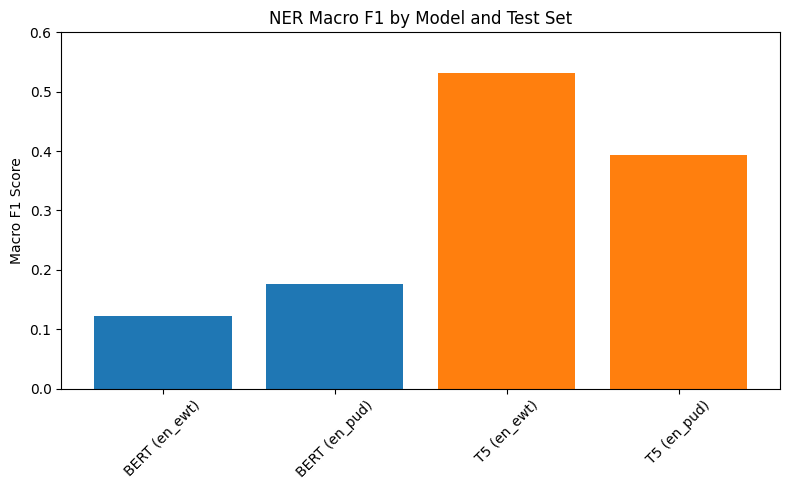

In [ ]:
# Model Performance Comparison Plot

import matplotlib.pyplot as plt
import pandas as pd

# Performance summary
df = pd.DataFrame({
    "Model": ["BERT", "BERT", "T5", "T5"],
    "Test Set": ["en_ewt", "en_pud", "en_ewt", "en_pud"],
    "Macro F1": [0.1226, 0.1757, 0.5316, 0.3940]
})

plt.figure(figsize=(8, 5))
bars = plt.bar(df["Model"] + " (" + df["Test Set"] + ")", df["Macro F1"], color=["#1f77b4", "#1f77b4", "#ff7f0e", "#ff7f0e"])
plt.ylabel("Macro F1 Score")
plt.title("NER Macro F1 by Model and Test Set")
plt.xticks(rotation=45)
plt.ylim(0, 0.6)
plt.tight_layout()
plt.show()


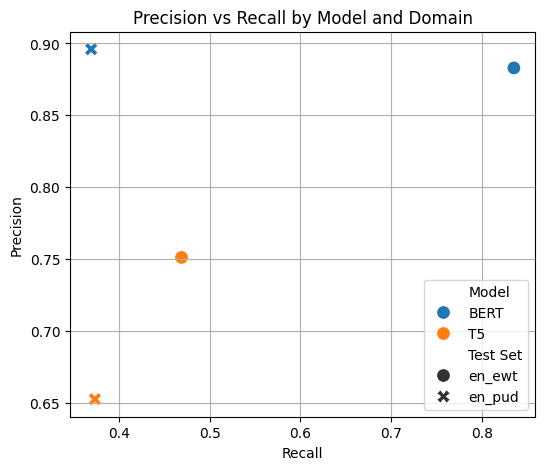

In [ ]:
# Precision vs Recall Scatter Plot

import seaborn as sns

# Data
performance = {
    "Model": ["BERT", "BERT", "T5", "T5"],
    "Test Set": ["en_ewt", "en_pud", "en_ewt", "en_pud"],
    "Precision": [0.8830, 0.8960, 0.7512, 0.6526],
    "Recall": [0.8356, 0.3690, 0.4687, 0.3731]
}

df_perf = pd.DataFrame(performance)

plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_perf, x="Recall", y="Precision", hue="Model", style="Test Set", s=100)
plt.title("Precision vs Recall by Model and Domain")
plt.grid(True)
plt.show()
